## Data Privacy Attack Examples

Running extraction and inversion attacks on example models for the energy company explainer

## 1. Reconstruction/Attribute attacks

In [1]:
import warnings
warnings.filterwarnings('ignore')
import keras.backend as k
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
import numpy as np
from numpy.random import seed
seed(123)

from art.estimators.classification import KerasClassifier
from art.attacks.inference.model_inversion.mi_face import MIFace
from art.utils import load_dataset

%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf
tf.compat.v1.disable_eager_execution()

2024-04-03 22:23:38.745285: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-03 22:23:38.745371: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-03 22:23:38.746224: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-03 22:23:38.752585: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-03 22:23:39.530305: W tensorflow/compiler/tf2

In [2]:
# Read MNIST dataset
(x_train, y_train), (x_test, y_test), min_, max_ = load_dataset(str('mnist'))

### Train model and initialize attack

In [3]:
# create standard CNN in Keras and wrap with ART KerasClassifier:
def cnn_mnist(input_shape, min_val, max_val):
  
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    classifier = KerasClassifier(clip_values=(min_val, max_val), 
                                model=model, use_logits=False)
    return classifier

We train this model, given this

In [11]:
num_epochs = 10

# construct and train a convolutional neural network
classifier = cnn_mnist(x_train.shape[1:], min_, max_)
classifier.fit(x_train, y_train, nb_epochs=num_epochs, batch_size=128, verbose = True) # set verbose is true to see perfformance of the data 

Train on 60000 samples
Epoch 1/10


2024-04-03 22:28:19.495807: W tensorflow/c/c_api.cc:305] Operation '{name:'training_4/Adam/dense_7/bias/m/Assign' id:1746 op device:{requested: '', assigned: ''} def:{{{node training_4/Adam/dense_7/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_4/Adam/dense_7/bias/m, training_4/Adam/dense_7/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


  256/60000 [..............................] - ETA: 49s - loss: 2.2859 - accuracy: 0.1133 

2024-04-03 22:28:19.732730: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indropout_3/cond/then/_140/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


60000/60000 [==============================] - 6s 99us/sample - loss: 0.2104 - accuracy: 0.9354
Epoch 2/10
60000/60000 [==============================] - 6s 93us/sample - loss: 0.0630 - accuracy: 0.9807
Epoch 3/10
60000/60000 [==============================] - 6s 92us/sample - loss: 0.0452 - accuracy: 0.9862
Epoch 4/10
60000/60000 [==============================] - 5s 92us/sample - loss: 0.0373 - accuracy: 0.9883
Epoch 5/10
60000/60000 [==============================] - 6s 92us/sample - loss: 0.0304 - accuracy: 0.9905
Epoch 6/10
60000/60000 [==============================] - 6s 97us/sample - loss: 0.0262 - accuracy: 0.9912
Epoch 7/10
60000/60000 [==============================] - 5s 89us/sample - loss: 0.0212 - accuracy: 0.9931
Epoch 8/10
60000/60000 [==============================] - 5s 90us/sample - loss: 0.0183 - accuracy: 0.9940
Epoch 9/10
60000/60000 [==============================] - 5s 90us/sample - loss: 0.0167 - accuracy: 0.9949
Epoch 10/10
60000/60000 [=======================

In [12]:
# Create the attack.
# Note: by setting the threshold to 1., the attack will effectively exhaust the maximum number of iterations.

attack = MIFace(classifier, max_iter=10000, threshold=1.) 

In [13]:
# Our attack target in the following will be to infer information about the training samples 
# for each of the 10 MNIST CLASSES:

y = np.arange(10)

In [14]:
# We will experiment with a number of different initializations:

# x_init_white = np.zeros((10, 28, 28, 1))
# x_init_grey = np.zeros((10, 28, 28, 1)) + 0.5
# x_init_black = np.ones((10, 28, 28, 1))
# x_init_random = np.random.uniform(0, 1, (10, 28, 28, 1))
x_init_average = np.zeros((10, 28, 28, 1)) + np.mean(x_test, axis=0)

### Initialization with average image

In [15]:
# First, we ensure that the classifier's gradients are non-vanishing for each target class:

class_gradient = classifier.class_gradient(x_init_average, y)
class_gradient = np.reshape(class_gradient, (10, 28*28))
class_gradient_max = np.max(class_gradient, axis=1)

print("Minimum over all maximum class gradient: %f" % (np.min(class_gradient_max)))

2024-04-03 22:29:49.261780: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indropout_3/cond/then/_140/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Minimum over all maximum class gradient: 0.014633


In [16]:
%%time

# Now we run the attack:
x_infer_from_average = attack.infer(x_init_average, y)

Model inversion:   0%|          | 0/10 [00:00<?, ?it/s]

2024-04-03 22:29:51.086758: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_7/Softmax' id:1450 op device:{requested: '', assigned: ''} def:{{{node dense_7/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_7/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


CPU times: user 15min 33s, sys: 6min 21s, total: 21min 54s
Wall time: 16min 38s


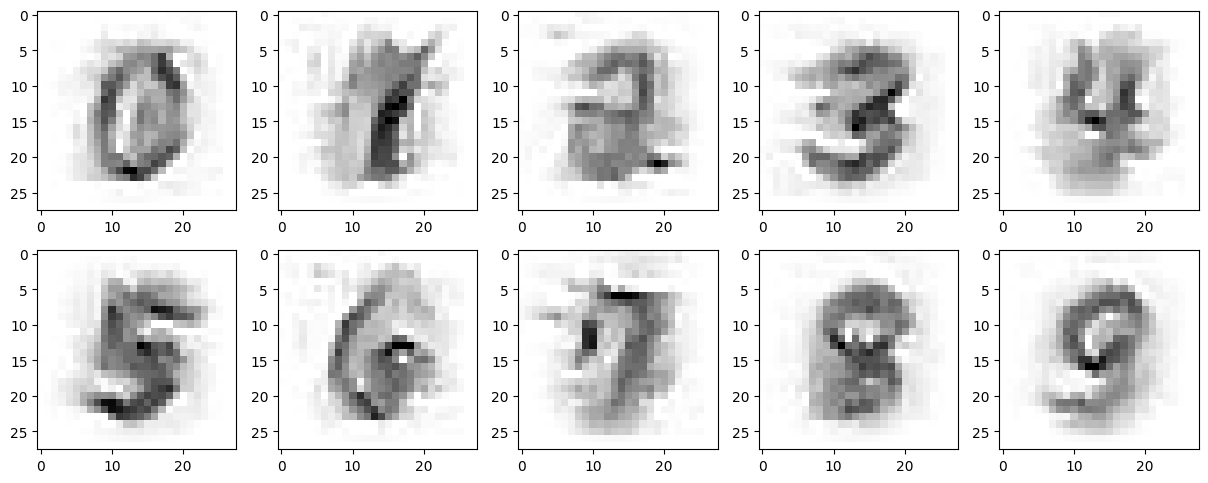

In [17]:
# Plot the inferred images:

plt.figure(figsize=(15,15))
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.imshow( (np.reshape(x_infer_from_average[0+i,], (28, 28))), cmap=plt.cm.gray_r)

## 2. Model Extraction - CopyCNN

Example of an attack based on the copy cat behaviour of a model

In [20]:
from art.attacks.extraction import CopycatCNN

In [21]:
# create a substitute model

input_shape = x_train.shape[1:]

min_val, max_val = min_, max_
substitute_model = Sequential()
substitute_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
substitute_model.add(MaxPooling2D(pool_size=(2, 2)))
substitute_model.add(Conv2D(64, (3, 3), activation='relu'))
substitute_model.add(MaxPooling2D(pool_size=(2, 2)))
substitute_model.add(Dropout(0.25))
substitute_model.add(Flatten())
substitute_model.add(Dense(128, activation='relu'))
substitute_model.add(Dense(10, activation='softmax'))

substitute_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

substitute_classifier = KerasClassifier(clip_values=(min_val, max_val), 
                            model=substitute_model, use_logits=False)

# substitute_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# substitute_classifier = TensorFlowV2Classifier(model=substitute_model, nb_classes=1000, input_shape=(224, 224, 3), loss_object=tf.keras.losses.CategoricalCrossentropy())

# create CopycatCNN attack
attack = CopycatCNN(classifier=classifier, batch_size_fit=64, batch_size_query=64, nb_epochs=10, nb_stolen=1000)

# get the classifier
# base on the training behaviour of models here for the workflow
thieved_classifier = attack.extract(x=x_train, y=np.argmax(classifier.predict(x = x_train), axis = 1), thieved_classifier=substitute_classifier)

2024-04-03 22:53:33.199772: W tensorflow/c/c_api.cc:305] Operation '{name:'count_4/Assign' id:2487 op device:{requested: '', assigned: ''} def:{{{node count_4/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count_4, count_4/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-04-03 22:53:36.333141: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_5/mul' id:2818 op device:{requested: '', assigned: ''} def:{{{node loss_5/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_5/mul/x, loss_5/dense_11_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-04-03 22:5

Checking the results on the test set

The code above, evaluates the test set for MNIST, which could work in real life, just describe it afterwards.

Here we evaluate the accuracy on the entire test set.

In [28]:
thieved_predictions = np.argmax(thieved_classifier.predict(x = x_test), axis = 1)
thieved_predictions

array([7, 2, 1, ..., 4, 5, 6])

In [29]:
victim_predictions = np.argmax(classifier.predict(x = x_test), axis = 1)
victim_predictions

array([7, 2, 1, ..., 4, 5, 6])

In [30]:
# evaluate the accuracy with respect to a particular model

acc = np.sum(victim_predictions==thieved_predictions)/len(victim_predictions)
acc

0.9438

In [35]:
y_test_ = np.array([np.argmax(x) for x in y_test])

In [36]:
y_test_ # getting true accuracy for the workflow here

array([7, 2, 1, ..., 4, 5, 6])

In [37]:
acc_true = np.sum(victim_predictions==y_test_)/len(victim_predictions)
acc_true

0.9919

## 3. Membership Inference attack

Do this with TensorFlow privacy here for the workflow

In [42]:
# have a different model that is useful here - check example and extrapolate.

# show chat gpt example - and showcase code here as well that's it!!

## 4. Model Leakage

In [40]:
from sklearn import svm
from sklearn.datasets import make_blobs
import numpy as np
import pandas as pd

# generate synthetic data
# 40 samples with 2 features representing energy_consumption and carbon_footprint
# half of these samples will be labeled high efficiency (1) and the other half low efficiency (0)
X, y = make_blobs(n_samples=40, centers=2, random_state=6, n_features=2)

# Convert to a more meaningful dataframe for visualization
df = pd.DataFrame(X, columns=['energy_consumption', 'carbon_footprint'])
df['efficiency'] = y

# train the SVM model
# For simplicity, we use a linear kernel
model = svm.SVC(kernel='linear', C=1.0)
model.fit(X, y)

# extract support vectors
support_vectors = model.support_vectors_

# output
df_support_vectors = pd.DataFrame(support_vectors, columns=['energy_consumption', 'carbon_footprint'])
df_support_vectors


,energy_consumption,carbon_footprint
0,7.270590,-4.842257
1,5.953136,-6.829460
2,7.893600,-7.416551


In [41]:
# check that the data is in energy consumption

# find the relevant results form the support vector mnachine for our model.

df[df.index.isin(model.support_)]

,energy_consumption,carbon_footprint,efficiency
16,7.270590,-4.842257,0
21,5.953136,-6.829460,1
30,7.893600,-7.416551,1


Here we see that for our model, we can extract relevant model information from our model.

However, this will require direct access for the model, or specific model details. It could be possible to estimate the support to extract out the data.

Similar model behaviour, we can perhaps extract out what these are. (other combined models) Discuss in a later section. Essentially, just check that this is the case!!

In [ ]:
# take straight forward code below and use it!!, edit it later for other uses!!

# combine files for the workflow where it's needed for review, and write up

# write up each attack in detail - and that's it, nothing else really needed - start with the detailed write up for the other sections, and then create the poster!!

## 5. Property Inference Attack

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np

# Step 1: Generate synthetic data
np.random.seed(42)  # For reproducibility
n_samples = 200
# Features: energy_production, carbon_emission
X = np.random.rand(n_samples, 2) * [100, 500]  # Scale features
# Assume renewable energy companies are defined by lower carbon emission for the same energy production
y = (X[:, 1] < (250 - X[:, 0] * 2.5)).astype(int)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Train a model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Test the model
predictions = model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)

accuracy

1.0

In [2]:
# generate synthetic data for property inference attack
n_inference_samples = 1000
X_inference = np.random.rand(n_inference_samples, 2) * [100, 500]

# use the trained model to predict on this synthetic data
inference_predictions = model.predict(X_inference)

# calculate the proportion of predictions that are for renewable energy companies
proportion_renewable_predictions = np.mean(inference_predictions)

proportion_renewable_predictions


0.223

In [3]:
actual_proportion_renewable_training = np.mean(y_train)

actual_proportion_renewable_training

0.28125

In [ ]:
# extract meaningful information - which could be useful - not 100% exact, but it is close - and we could make use of it.

# that's the idea - maybe add some more synthetic data here for this - but that's the idea

# edit this, and start write up tomorrow!!

# Attack and defence strategy

## TensorFlow privacy

In [1]:
# MIA seen attack strategy now, now implement the tensorflow privacy strategy here.